<a href="https://colab.research.google.com/github/joepro0118-create/dsAssignment/blob/main/dsassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

# put your exact parquet filename here (copy from the Colab file list)
file_path = "/content/sample_data/yellow_tripdata_2025-01.parquet"

df = pd.read_parquet(file_path)
df.shape, df.head()

((3475226, 20),
    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
 0         1  2025-01-01 00:18:38   2025-01-01 00:26:59              1.0   
 1         1  2025-01-01 00:32:40   2025-01-01 00:35:13              1.0   
 2         1  2025-01-01 00:44:04   2025-01-01 00:46:01              1.0   
 3         2  2025-01-01 00:14:27   2025-01-01 00:20:01              3.0   
 4         2  2025-01-01 00:21:34   2025-01-01 00:25:06              3.0   
 
    trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
 0           1.60         1.0                  N           229           237   
 1           0.50         1.0                  N           236           237   
 2           0.60         1.0                  N           141           141   
 3           0.52         1.0                  N           244           244   
 4           0.66         1.0                  N           244           116   
 
    payment_type  fare_amount  extra  mta_ta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once your Drive is mounted, you can copy your file to a persistent location within it. For example, to copy the `.parquet` file to a `data` folder in your `Colab Notebooks` directory in Google Drive, you could use a command like this:

```bash
!cp "/content/sample_data/yellow_tripdata_2025-01.parquet" "/content/drive/MyDrive/Colab Notebooks/data/yellow_tripdata_2025-01.parquet"
```

**Make sure to create the `data` folder in your Google Drive if it doesn't already exist.**

After copying, update the `file_path` variable in your notebook to point to the new location in Google Drive, for example:

```python
file_path = "/content/drive/MyDrive/Colab Notebooks/data/yellow_tripdata_2025-01.parquet"
```

In [ ]:
df.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np

# df already loaded from parquet
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')

df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# basic cleaning
df = df.dropna(subset=['trip_duration_min', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID'])
df = df[(df['trip_duration_min'] > 0) & (df['trip_duration_min'] <= 180)]          # remove weird trips
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 50)]                   # remove weird distances
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]               # typical taxi range

# optional: sample for speed
df_model = df.sample(100000, random_state=42) if len(df) > 100000 else df.copy()
if len(df) > 100000:
    df = df.sample(100000, random_state=42)


df.shape

(100000, 24)

In [ ]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

In [ ]:
features = ['trip_distance','passenger_count','pickup_hour','pickup_dayofweek',
            'PULocationID','DOLocationID','payment_type']
target = 'trip_duration_min'

X = df[features].copy()
y = df[target].copy()

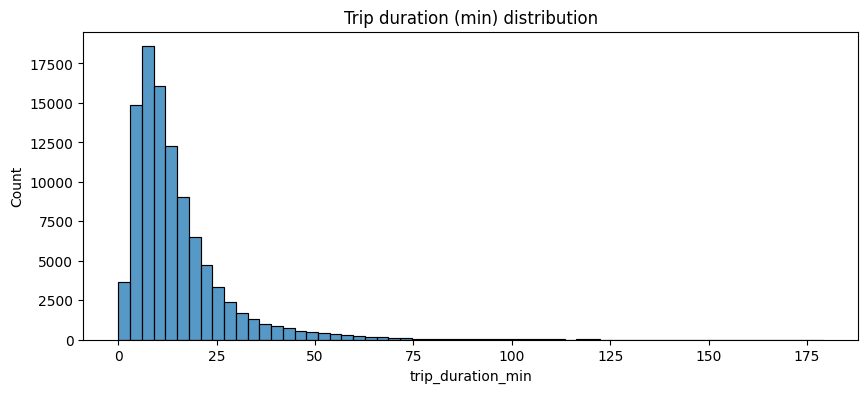

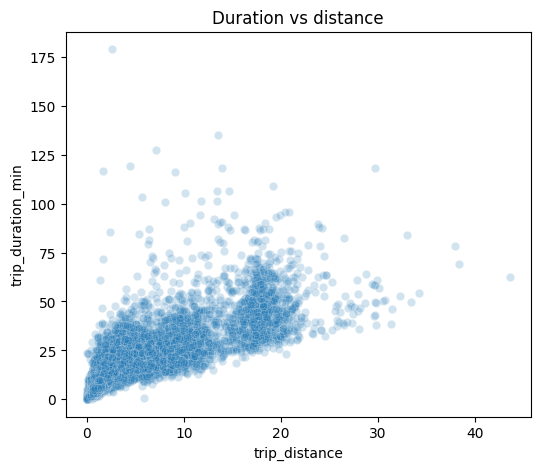

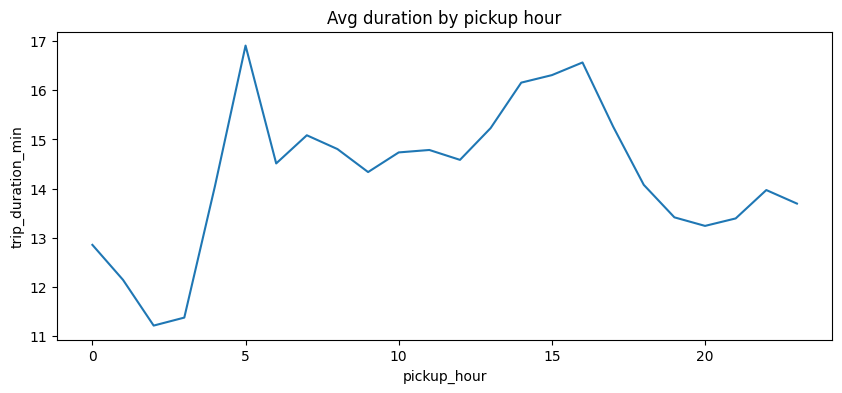

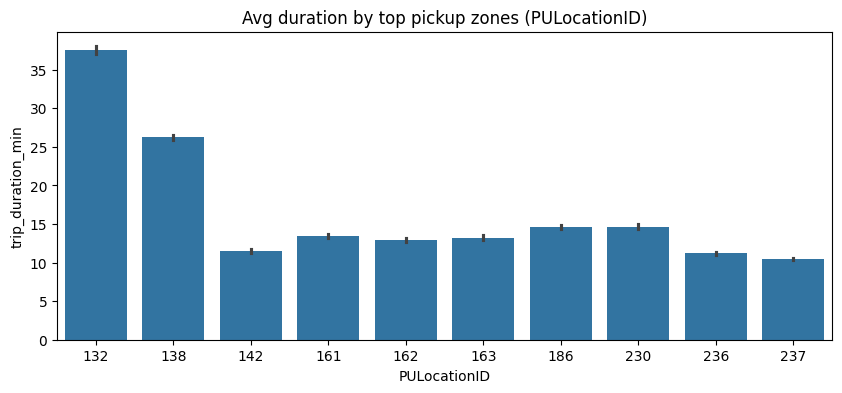

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.histplot(df['trip_duration_min'], bins=60)
plt.title("Trip duration (min) distribution")
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(data=df.sample(min(len(df), 20000), random_state=42),
                x='trip_distance', y='trip_duration_min', alpha=0.2)
plt.title("Duration vs distance")
plt.show()

plt.figure(figsize=(10,4))
sns.lineplot(data=df.groupby('pickup_hour', as_index=False)['trip_duration_min'].mean(),
             x='pickup_hour', y='trip_duration_min')
plt.title("Avg duration by pickup hour")
plt.show()

top_pu = df['PULocationID'].value_counts().head(10).index
plt.figure(figsize=(10,4))
sns.barplot(data=df[df['PULocationID'].isin(top_pu)],
            x='PULocationID', y='trip_duration_min', estimator=np.mean)
plt.title("Avg duration by top pickup zones (PULocationID)")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = ['PULocationID','DOLocationID','payment_type']
num_cols = ['trip_distance','passenger_count','pickup_hour','pickup_dayofweek']

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

def evaluate(name, preds):
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds)) # Calculate RMSE by taking square root of MSE
    r2 = r2_score(y_test, preds)
    return {'model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Baseline (mean)
baseline_pred = np.full(shape=len(y_test), fill_value=y_train.mean())
results = [evaluate('BaselineMean', baseline_pred)]

# Ridge
ridge = Pipeline([
    ('prep', preprocess),
    ('model', Ridge(alpha=1.0, random_state=42))
])
ridge.fit(X_train, y_train)
results.append(evaluate('Ridge', ridge.predict(X_test)))

# Random Forest (good without tuning)
rf = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=80,
        random_state=42,
        n_jobs=-1,
        max_depth=20
    ))
])
rf.fit(X_train, y_train)
results.append(evaluate('RandomForest', rf.predict(X_test)))

results_df = pd.DataFrame(results).sort_values('MAE')
results_df

,model,MAE,RMSE,R2
2,RandomForest,3.141518,5.487878,0.785649
1,Ridge,4.166250,6.464575,0.702563
0,BaselineMean,8.146177,11.853388,-0.000002


In [ ]:
table1_vars = [
    'trip_duration_min',      # target
    'trip_distance',
    'passenger_count',
    'pickup_hour',
    'pickup_dayofweek',
    'PULocationID',
    'DOLocationID',
    'payment_type',
    'fare_amount',
    'total_amount'
]

def table1_row(df, col):
    s = df[col]
    return {
        "Variable": col,
        "Type (Num/Cat)": "Numeric" if pd.api.types.is_numeric_dtype(s) else "Categorical",
        "Data type": str(s.dtype),
        "Unique values": int(s.nunique(dropna=True)),
        "Null values": int(s.isna().sum()),
        "Min": float(s.min()) if pd.api.types.is_numeric_dtype(s) else "",
        "Max": float(s.max()) if pd.api.types.is_numeric_dtype(s) else "",
    }

table1 = pd.DataFrame([table1_row(df, c) for c in table1_vars if c in df.columns])
# Round 'Min' and 'Max' columns to two decimal places for display
table1[['Min', 'Max']] = table1[['Min', 'Max']].round(2)
table1

,Variable,Type (Num/Cat),Data type,Unique values,Null values,Min,Max
0,trip_duration_min,Numeric,float64,4254,0,0.03,179.05
1,trip_distance,Numeric,float64,2479,0,0.01,49.50
2,passenger_count,Numeric,float64,6,0,1.00,6.00
3,pickup_hour,Numeric,int32,24,0,0.00,23.00
4,pickup_dayofweek,Numeric,int32,7,0,0.00,6.00
5,PULocationID,Numeric,int32,220,0,1.00,265.00
6,DOLocationID,Numeric,int32,251,0,1.00,265.00
7,payment_type,Numeric,int64,4,0,1.00,4.00
8,fare_amount,Numeric,float64,687,0,-209.50,350.00
9,total_amount,Numeric,float64,6332,0,-222.19,369.54


In [ ]:
table1.to_csv("Table1_DataProperties.csv", index=False)

In [ ]:
# ===== Table 2: Descriptive Statistics with Quartiles + Kurtosis =====

# Choose numeric columns for descriptive stats (include target)
num_cols = [
    'trip_duration_min',
    'trip_distance',
    'passenger_count',
    'pickup_hour',
    'pickup_dayofweek',
    'fare_amount',
    'tip_amount',
    'total_amount'
]
num_cols = [c for c in num_cols if c in df.columns]

# describe gives: count, mean, std, min, 25%, 50%, 75%, max
desc = df[num_cols].describe(percentiles=[0.25, 0.50, 0.75]).T

# add extra stats
desc["variance"] = df[num_cols].var(numeric_only=True)
desc["skewness"] = df[num_cols].skew(numeric_only=True)
desc["kurtosis"] = df[num_cols].kurtosis(numeric_only=True)  # Fisher kurtosis (0 = normal)

# optional: nicer column names
table2 = desc.rename(columns={
    "25%": "Q1 (25%)",
    "50%": "Median (50%)",
    "75%": "Q3 (75%)"
})

# Round all numeric columns in table2 to two decimal places for display
table2 = table2.round(2)

table2

,count,mean,std,min,Q1 (25%),Median (50%),Q3 (75%),max,variance,skewness,kurtosis
trip_duration_min,100000.0,14.61,11.85,0.03,7.03,11.33,18.17,179.05,140.35,2.56,10.94
trip_distance,100000.0,3.19,4.29,0.01,0.98,1.62,3.00,49.50,18.40,2.89,9.42
passenger_count,100000.0,1.31,0.74,1.00,1.00,1.00,1.00,6.00,0.55,3.16,11.61
pickup_hour,100000.0,14.39,5.53,0.00,11.00,15.00,19.00,23.00,30.59,-0.63,-0.04
pickup_dayofweek,100000.0,3.03,1.84,0.00,2.00,3.00,4.00,6.00,3.37,-0.02,-1.04
fare_amount,100000.0,17.21,17.62,-209.50,8.60,12.10,19.10,350.00,310.38,2.14,15.17
tip_amount,100000.0,3.43,3.78,-0.01,1.00,2.85,4.21,99.99,14.29,3.43,29.78
total_amount,100000.0,26.35,22.42,-222.19,15.60,20.19,28.25,369.54,502.77,1.99,11.13


In [ ]:
table2.to_csv("Table2_DescriptiveStats_Quartiles_Kurtosis.csv")